In [1]:
# Import Libraries

import numpy as np
import scipy as sc

import matplotlib.pyplot as plt
from math import cos, sin, atan

from matplotlib.backends.backend_qt5agg import FigureCanvasQTAgg as FigureCanvas
from matplotlib.figure import Figure

import time
from IPython.display import clear_output

In [2]:
class RedConfig():
    def __init__(self, learning_ratio = 0.01, iteration_limit = 1000, err_max = 0.1, graphic_resolution = 50, interval_show = 2):
        self.__learning_ratio = learning_ratio
        self.__iteration_limit = iteration_limit
        self.__err_max = err_max
        self.__graphic_resolution = graphic_resolution
        self.__interval_show = interval_show
        
    def get_learning_ratio(self):
        return self.__learning_ratio
    
    def get_iteration_limit(self):
        return self.__iteration_limit
    
    def get_err_max(self):
        return self.__err_max
    
    def get_graphic_resolution(self):
        return self.__graphic_resolution
    
    def get_interval_show(self):
        return self.__interval_show
    
    
    
    def set_learning_ratio(self, _learning_ratio):
        try:
            self.__learning_ratio = _learning_ratio
        except:
            return False
        return True
    
    def set_iteration_limit(self, _iteration_limit):
        try:
            self.__iteration_limit = _iteration_limit
        except:
            return False
        return True
        
    def set_err_max(self, _err_max):
        try:
            self.__err_max = _err_max
        except:
            return False
        return True
    
    def set_graphic_resolution(self, _graphic_resolution):
        try:
            self.__graphic_resolution = _graphic_resolution
        except:
            return False
        return True
    
    def set_interval_show(self, _interval_show):
        try:
            self.__interval_show = _interval_show
        except:
            return False
        return True

## File Manager Class

In [3]:
class FileManager():
    
    def __init__(self, project_path):
        
        self.project_name = project_path.split("/")[-1]
        self.project_path = project_path.replace(self.project_name, "")
        self.dataset_path = ""
        self.delimiter_format = ""
        
        
    def count_in_out(self):
        
        first_row = np.loadtxt(self.dataset_path, delimiter = self.delimiter_format, dtype=str, max_rows=1)
        
        n_XY = [0,0]
        
        for l, _data in enumerate(first_row):
            if "X" in str.upper(first_row[l]):
                n_XY[0] += 1 
            if "Y" in str.upper(first_row[l]):
                n_XY[1] += 1 
                
        return n_XY
    
    
    # Import data
    def import_dataset(self, cols = []):
        data = np.loadtxt(self.dataset_path, delimiter=self.delimiter_format, skiprows=1, usecols=cols, dtype=float)
        return data
    
    def import_file(self, file_name = ""):
        data = np.loadtxt(file_name, delimiter=self.delimiter_format, usecols=None, dtype=str)
        return data
    

## Canvas for plot

In [4]:
class Canvas(FigureCanvas):

    def __init__(self, parent=None):
        fig = Figure()
        self.axes = fig.add_subplot(111)

        self.compute_initial_figure()

        FigureCanvas.__init__(self, fig)
        self.setParent(parent)

        FigureCanvas.setSizePolicy(self,
                                   QSizePolicy.Expanding,
                                   QSizePolicy.Expanding)
        FigureCanvas.updateGeometry(self)

    def compute_initial_figure(self):
        pass

## Neural Network: rustic graphic

In [5]:
class GraphicNeuron():
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def draw(self, neuron_radius):
        circle = plt.Circle((self.x, self.y), radius=neuron_radius, fill=False)
        plt.gca().add_patch(circle)

In [6]:
class GraphicLayer():
    def __init__(self, network, number_of_neurons, number_of_neurons_in_widest_layer):
        self.vertical_distance_between_layers = 6
        self.horizontal_distance_between_neurons = 2
        self.neuron_radius = 0.5
        self.number_of_neurons_in_widest_layer = number_of_neurons_in_widest_layer
        self.previous_layer = self.__get_previous_layer(network)
        self.y = self.__calculate_layer_y_position()
        self.neurons = self.__intialise_neurons(number_of_neurons)

    def __intialise_neurons(self, number_of_neurons):
        neurons = []
        x = self.__calculate_left_margin_so_layer_is_centered(number_of_neurons)
        for iteration in range(number_of_neurons):
            neuron = GraphicNeuron(x, self.y)
            neurons.append(neuron)
            x += self.horizontal_distance_between_neurons
        return neurons

    def __calculate_left_margin_so_layer_is_centered(self, number_of_neurons):
        return self.horizontal_distance_between_neurons * (self.number_of_neurons_in_widest_layer - number_of_neurons) / 2

    def __calculate_layer_y_position(self):
        if self.previous_layer:
            return self.previous_layer.y + self.vertical_distance_between_layers
        else:
            return 0

    def __get_previous_layer(self, network):
        if len(network.layers) > 0:
            return network.layers[-1]
        else:
            return None

    def __line_between_two_neurons(self, neuron1, neuron2):
        angle = atan((neuron2.x - neuron1.x) / float(neuron2.y - neuron1.y))
        x_adjustment = self.neuron_radius * sin(angle)
        y_adjustment = self.neuron_radius * cos(angle)
        line = plt.Line2D((neuron1.x - x_adjustment, neuron2.x + x_adjustment), (neuron1.y - y_adjustment, neuron2.y + y_adjustment))
        plt.gca().add_line(line)

    def draw(self, layerType=0):
        for neuron in self.neurons:
            neuron.draw( self.neuron_radius )
            if self.previous_layer:
                for previous_layer_neuron in self.previous_layer.neurons:
                    self.__line_between_two_neurons(neuron, previous_layer_neuron)
        # write Text
        x_text = self.number_of_neurons_in_widest_layer * self.horizontal_distance_between_neurons
        if layerType == 0:
            plt.text(x_text, self.y, 'Capa de Entrada', fontsize = 12)
        elif layerType == -1:
            plt.text(x_text, self.y, 'Capa de Salida ', fontsize = 12)
        else:
            plt.text(x_text, self.y, 'Capa Oculta '+str(layerType), fontsize = 12)

In [7]:
class GraphicNeuralNetwork():
    def __init__(self, number_of_neurons_in_widest_layer):
        self.number_of_neurons_in_widest_layer = number_of_neurons_in_widest_layer
        self.layers = []
        self.layertype = 0

    def add_layer(self, number_of_neurons ):
        layer = GraphicLayer(self, number_of_neurons, self.number_of_neurons_in_widest_layer)
        self.layers.append(layer)

    def draw(self):
        plt.figure()
        for i in range( len(self.layers) ):
            layer = self.layers[i]
            if i == len(self.layers)-1:
                i = -1
            layer.draw( i )
        plt.axis('scaled')
        plt.axis('off')
        plt.show()

## Dataset

In [8]:
class Dataset():
    def __init__(self, n_XY):
        self.n_X = n_XY[0]
        self.n_Y = n_XY[1]
        self.X = []
        self.Y = []
        
        
    def import_X_dataset(self, file_manager):
        cols = []
        
        for i_x in range(0, self.n_X):
            cols.append(i_x)
        
        self.X = file_manager.import_dataset(cols)
        
    def import_Y_dataset(self, file_manager):
        cols = []
        
        for i_y in range(self.n_X, self.n_X + self.n_Y):
            cols.append(i_y)
            
        self.Y = file_manager.import_dataset(cols)
        self.fix_Y_axis()
        
    def fix_Y_axis(self):
        self.Y = self.Y[:, np.newaxis]

## Data Structure: neural layer

In [9]:
# Neural layer builder

class NeuralLayer():
    # The class is initialized receiving the parameters:
    # n_conn: connections number, neurons of layer before
    # n_neur: neurons number
    # act_f: activation function
    
    def __init__ (self, n_connection, n_neuron, activation_function):
        
        self.activation_function = activation_function
        self.W = np.random.rand(n_connection, n_neuron) * 2 - 1 
        self.b = np.random.rand(1, n_neuron) * 2 - 1 

## Activation functions

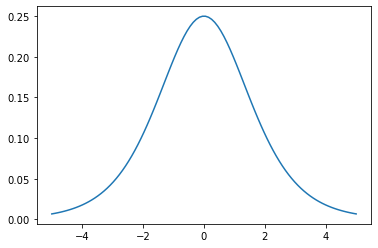

In [10]:
class ActivationFunction():
    def __init__(self):
    
        self.step = lambda x: x >= 0

        self.sigm = (lambda x: 1 / (1 + np.exp(-x)), 
                     lambda x: (lambda value=self.sigm[0](x): value * (1 - value))()
                    )

        self.relu = (lambda x: np.maximum(0, x),
                     lambda x: x > 0
                    )

        self.tanh = (lambda x: np.tanh(x),
                     lambda x: 1.0 - (np.tanh(x) ** 2)
                    )
        
        self.linear = (lambda x: x,
                       lambda x: 1
                      )
        
#         self.gauss = (lambda x: ,
#                      lambda x: 
#                     )



active = ActivationFunction()
_x = np.linspace(-5,5,100)   # Variable que vaya de 5 a -5 y genera 100 valores
plt.plot(_x,active.sigm[1](_x))

## Neural Network: Logic

In [11]:
class NeuralNetwork():
    
    def __init__(self, topology, activation_function, red_config, dataset):
        
        self.topology = topology
        self.activation_function = activation_function
        
        self.dataset = dataset
        self.red_config = red_config
        
        self.cost_function = (lambda Yp, Yr: np.mean((Yp - Yr) ** 2),
                              lambda Yp, Yr: (Yp - Yr)
                             )
        self.create_nn()

    
    def create_nn(self):

        # Vector containing the layers that make up the network
        self.neural_network = []
        # Review the neural network topology and create the layers
        for l, layer in enumerate(self.topology[:-1]):

            self.neural_network.append(NeuralLayer(self.topology[l], self.topology[l+1], self.activation_function[l+1]))
            
    
    def solve_unknow_dataset(self, X):
        
        out = [(None, X)]
        
        for l, layer in enumerate(self.neural_network):
            
            self.feedforward(l, out)
            
        return out[-1][1]
    
    
    def train(self, backpropagation, backpropagation_type):
        
        out = [(None, self.dataset.X)]
        
        for l, layer in enumerate(self.neural_network):
            
            self.feedforward(l, out)
            
        if backpropagation:

            self.backward(out, backpropagation_type)

        else:

            self.normal_Wb_update(l, out)
            
        return out[-1][1]
        
    
    def feedforward(self, l, out):
        
        # Weighted sum of layer[l]
        z = out[-1][1] @ self.neural_network[l].W + self.neural_network[l].b

        # Activation value of layer[l]
        a = self.neural_network[l].activation_function[0](z)
        
        # Save both values of layer[l] to vector
        out.append((z,a))
        
        
    def backward(self, out, backpropagation_type):
        
        δ = []
        
        for l in reversed(range(0, len(self.neural_network))):
            
            z = out[l+1][0]
            a = out[l+1][1]
            
            if l == len(self.neural_network)-1 :
                
                δ.insert(0, self.cost_function[1](a, self.dataset.Y) * self.neural_network[l].activation_function[1](z))
                
            else:
                
                δ.insert(0, δ[0] @ _W.T * self.neural_network[l].activation_function[1](z))
                
            _W = self.neural_network[l].W
            
            #GRADIENT DESCENT
            
            ##Primitive = 0 ; Cascade = 1
            if backpropagation_type:
                self.neural_network[l].b = self.neural_network[l].b - np.mean(δ[0], axis=0, keepdims=True) * self.red_config.get_learning_ratio()
                self.neural_network[l].W = self.neural_network[l].W - out[l][1].T @ δ[0] * self.red_config.get_learning_ratio()
            else:
                self.neural_network[l].b = self.neural_network[l].b + np.mean(δ[0], axis=0, keepdims=True) * self.red_config.get_learning_ratio()
                self.neural_network[l].W = self.neural_network[l].W + out[l][1].T @ δ[0] * self.red_config.get_learning_ratio()
            
    def normal_Wb_update(self, out):
        
        δ = []
        
        for l in range(1, len(self.neural_network)):
            
            z = out[l-1][0]
            a = out[l-1][0]
            
            if l == len(self.neural_network)-1 :
                
                δ.append(self.cost_function[1](a, self.dataset.Y))
                
            else:
                
                δ.append(δ[-1] @ _W.T)
                
            _W = self.neural_network[l].W
        
            self.neural_network[l].b = self.neural_network[l].b + np.mean(δ[-1], axis=0, keepdims=True) * self.red_config.get_learning_ratio()
        
            self.neural_network[l].W = self.neural_network[l].W + out[l][1].T @ δ[-1] * self.red_config.get_learning_ratio()
            

    def execute(self):
        
        err_iterations = []
        
        
        

In [12]:
def test(x):
    global x
    x = 1
    x = x + 1

print(x)

SyntaxError: name 'x' is parameter and global (<ipython-input-12-ebd24a7b408a>, line 2)